# Conclusions
To improve results the following experiments shouled be run and tracked:
* Find more variabes that describe customers 
* Check various sampling strategies
* Determine what level of precision and recall are acceptable
* Check what should be optimized: maximize number of correct decisions, max profit, any other business metric? 
interesting doc on threshold selection: [http://research.google.com/bigpicture/attacking-discrimination-in-ml/] 

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import pickle

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTENC, RandomOverSampler

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, roc_curve, precision_recall_curve

pd.options.display.max_rows = 40
pd.options.display.max_columns = 999999
seed = 12345

In [2]:
import os
os.chdir("..")

In [3]:
from src.data.udfs_data_prep import compute_counts_and_share, convert_object_cols_to_category
from src.models.udfs_modelling import get_summary, reclassify_by_treshold, compute_f1, summarise_metrices, get_confusion_matrix, format_confusion_matrix
from src.models.udfs_modelling import get_rf_feature_imp, extract_and_plot_hyperopt_trials, save_intermin_data_and_model

# Data load

In [4]:
df_merged = pd.read_pickle('data/processed/df_application_record_classified_post_feature_eng.pickle')

In [5]:
df_merged.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,target
id,,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008805,1,1,1,0,427500.0,Working,Higher education,Rented apartment,Unknown,2,213750.0,32.890411,12.443836,1,0,0
5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,House / apartment,Security staff,2,56250.0,58.832877,3.106849,1,0,0
5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0
5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,House / apartment,Sales staff,1,270000.0,52.356164,8.358904,1,1,0


In [6]:
df_merged.shape

(19996, 16)

In [7]:
df_merged.isnull().sum()

code_gender              0
flag_own_car             0
flag_own_realty          0
cnt_children             0
amt_income_total         0
name_income_type         0
name_education_type      0
name_housing_type        0
occupation_type          0
cnt_fam_members          0
amt_income_per_person    0
age                      0
job_tenure               0
flag_employed            0
single_adult             0
target                   0
dtype: int64

compute_counts_and_share# Train test spli

In [8]:
compute_counts_and_share(df_merged, 'target')

,count,share
0,19687,0.984547
1,309,0.015453


# Data preprocessing

In [9]:
y = df_merged['target']
X = df_merged.drop('target', axis = 1)

In [10]:
X.loc[:, X.select_dtypes("object_").columns]

,name_income_type,name_education_type,name_housing_type,occupation_type
id,,,,
5008804,Working,Higher education,Rented apartment,Unknown
5008805,Working,Higher education,Rented apartment,Unknown
5008806,Working,Secondary / secondary special,House / apartment,Security staff
5008810,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
5008811,Commercial associate,Secondary / secondary special,House / apartment,Sales staff
...,...,...,...,...
5149729,Working,Secondary / secondary special,House / apartment,Unknown
5149775,Working,Secondary / secondary special,House / apartment,Laborers
5149834,Commercial associate,Higher education,House / apartment,Medicine staff


## PCA 

In [11]:
X_pca = X.copy()
cat_features = X.select_dtypes("object_").columns

lbl_encode = LabelEncoder()
for i in cat_features:
    X_pca[i] = X_pca[[i]].apply(lbl_encode.fit_transform)
X_pca.loc[:, cat_features].head()
X_pca.head()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_housing_type,occupation_type,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult
id,,,,,,,,,,,,,,,
5008804,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008805,1,1,1,0,427500.0,4,1,4,17,2,213750.0,32.890411,12.443836,1,0
5008806,1,1,1,0,112500.0,4,4,1,16,2,56250.0,58.832877,3.106849,1,0
5008810,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1
5008811,0,0,1,0,270000.0,0,4,1,14,1,270000.0,52.356164,8.358904,1,1


In [12]:
scaler_pca = StandardScaler()
cols_to_scale_pca = ['cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure']
scaler = scaler_pca.fit(X_pca.loc[:,cols_to_scale_pca])

X_pca.loc[:,cols_to_scale_pca] = scaler.transform(X_pca.loc[:,cols_to_scale_pca])

In [13]:
pca = PCA()
X_components = pca.fit_transform(X_pca)
X_components = X_components[:, 0:3]

# # Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_components.shape[1])]
component_names
X_components = pd.DataFrame(X_components, columns=component_names)
X_components
X = pd.concat([X, X_components.set_index(X.index)], axis=1)

## Data split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state = 123)

## Scaling

In [15]:
X_train.describe()

,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,cnt_fam_members,amt_income_per_person,age,job_tenure,flag_employed,single_adult,PC1,PC2,PC3
count,15996.000000,15996.000000,15996.000000,15996.000000,1.599600e+04,15996.00000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000,15996.000000
mean,0.335021,0.388097,0.659227,0.432796,1.876312e+05,2.21049,99992.469870,44.137656,6.196185,0.837709,0.222993,0.001580,0.007490,0.000492
std,0.472013,0.487332,0.473984,0.736354,1.017679e+05,0.90327,71653.033018,11.292522,6.848725,0.368729,0.416267,5.652600,1.764610,1.495467
min,0.000000,0.000000,0.000000,0.000000,2.700000e+04,1.00000,9000.000000,21.252055,-1.000000,0.000000,0.000000,-7.687200,-6.307790,-7.522878
25%,0.000000,0.000000,0.000000,0.000000,1.215000e+05,2.00000,56250.000000,34.602740,1.200000,1.000000,0.000000,-6.314600,-1.401220,-1.003496
50%,0.000000,0.000000,1.000000,0.000000,1.575000e+05,2.00000,78750.000000,43.139726,4.597260,1.000000,0.000000,0.544931,0.288792,-0.102796
75%,1.000000,1.000000,1.000000,1.000000,2.250000e+05,3.00000,123750.000000,53.375342,8.934932,1.000000,0.000000,4.564596,1.520291,0.785698
max,1.000000,1.000000,1.000000,14.000000,1.575000e+06,15.00000,900000.000000,68.909589,42.906849,1.000000,1.000000,10.831413,7.733730,16.786272


In [16]:
scaler = StandardScaler()
cols_to_scale = [ 'cnt_children', 'amt_income_total', 'cnt_fam_members',
                 'amt_income_per_person', 'age', 'job_tenure',
                 'PC1', 'PC2', 'PC3']
scaler = scaler.fit(X_train.loc[:,cols_to_scale])

X_train.loc[:,cols_to_scale] = scaler.transform(X_train.loc[:,cols_to_scale])
X_test.loc[:,cols_to_scale] = scaler.transform(X_test.loc[:,cols_to_scale])

## Sampling

In [17]:
compute_counts_and_share(pd.DataFrame({'target': y_train}), 'target')

,count,share
0,15749,0.984559
1,247,0.015441


In [18]:
undersample = RandomUnderSampler(sampling_strategy = 0.1)
X_train_balanced, y_train_balanced = undersample.fit_resample(X_train, y_train)

In [19]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.909091
1,247,0.090909


In [20]:
# oversample = SMOTENC(random_state=seed,
#                      sampling_strategy = 0.9,
#                      categorical_features=[X_train.columns.isin(['name_income_type', 'name_education_type',
#                                                                  'name_housing_type', 'occupation_type'])])

oversample = RandomOverSampler(random_state=seed,
                     sampling_strategy = 0.9)

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train_balanced, y_train_balanced)

In [21]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


## One hot encoding

In [22]:
cat_vars = X_train_balanced.select_dtypes("object_").columns

In [23]:
enc = OneHotEncoder(handle_unknown = 'infrequent_if_exist', min_frequency = 30)
enc = enc.fit(X_train_balanced.loc[:, cat_vars])

In [24]:
X_train_balanced_one_hot = enc.transform(X_train_balanced.loc[:, cat_vars]).toarray()
X_test_one_hot = enc.transform(X_test.loc[:, cat_vars]).toarray()

In [25]:
X_train_balanced_one_hot = pd.DataFrame(X_train_balanced_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
X_train_balanced_one_hot = X_train_balanced_one_hot.set_index(X_train_balanced.index)

X_test_one_hot = pd.DataFrame(X_test_one_hot,
                                        columns = enc.get_feature_names_out().tolist())
X_test_one_hot = X_test_one_hot.set_index(X_test.index)

In [26]:
# X_train_balanced_one_hot = pd.concat([X_train_balanced.drop(cat_vars, axis = 1), X_train_balanced_one_hot.set_index(X_train_balanced.index)], axis=1)
# X_test_one_hot = pd.concat([X_test.drop(cat_vars, axis = 1), X_test_one_hot.set_index(X_test.index)], axis=1)

In [27]:
X_train_balanced_one_hot = X_train_balanced.drop(cat_vars, axis = 1).join(X_train_balanced_one_hot)
X_test_one_hot = X_test.drop(cat_vars, axis = 1).join(X_test_one_hot)

## Under-sampling: Tomek links

In [28]:
undersample_tomek = TomekLinks(sampling_strategy = 'majority')
(X_train_balanced_one_hot, y_train_balanced_one_hot) = undersample_tomek.fit_resample(X_train_balanced_one_hot, y_train_balanced)

In [29]:
compute_counts_and_share(pd.DataFrame({'target': y_train_balanced_one_hot}), 'target')

,count,share
0,2470,0.526316
1,2223,0.473684


# Modelling

## Try different models with default parameters

In [30]:
classifiers = {
    "LogisticRegression" : LogisticRegression(max_iter = 300, class_weight='balanced'),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(class_weight='balanced'),
    "RandomForest" : RandomForestClassifier(class_weight='balanced'),
    "XGBoost" : XGBClassifier(scale_pos_weight=10),
    "LGBMClassifier" : lgb.LGBMClassifier(class_weight='balanced')
}

In [31]:
# from sklearn.model_selection import cross_validate
train_cv_scores = []
test_scores = []

for key, classifier in classifiers.items():
    print(key)
    if key == "LGBMClassifier":
        X_train_data = convert_object_cols_to_category(X_train_balanced)
        y_train_data = y_train_balanced
        X_test_data = convert_object_cols_to_category(X_test)
        y_test_data = y_test

        classifier.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    else:
        X_train_data = X_train_balanced_one_hot
        y_train_data = y_train_balanced_one_hot
        X_test_data = X_test_one_hot
        y_test_data = y_test
        
        classifier.fit(X_train_data, y_train_data)
        
    train_cv_score = cross_val_score(classifier, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    train_cv_scores.append(train_cv_score)
    test_predictions = classifier.predict(X_test_data)
    test_score = average_precision_score(y_test_data, test_predictions)
    test_scores.append(test_score)  

LogisticRegression
KNeighbors
DecisionTree
RandomForest
XGBoost
LGBMClassifier


C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


In [32]:
print(train_cv_scores)
print(test_scores)

[0.6184558588500375, 0.9064880890096424, 0.9161066667703566, 0.9883980581193731, 0.9878625878049327, 0.9882565593942545]
[0.015538403885357956, 0.03229899254092802, 0.044400083787180564, 0.08823154729360307, 0.04241001697792869, 0.053463355970571586]


In [33]:
models_comparison = pd.DataFrame({'model': classifiers.keys(), 'train_mean_score': train_cv_scores, 'test_score': test_scores})
models_comparison

,model,train_mean_score,test_score
0,LogisticRegression,0.618456,0.015538
1,KNeighbors,0.906488,0.032299
2,DecisionTree,0.916107,0.044400
3,RandomForest,0.988398,0.088232
4,XGBoost,0.987863,0.042410
5,LGBMClassifier,0.988257,0.053463


## Hyperparameter tuning for lgbm

In [34]:
lgbm_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'learning_rate':    hp.uniform('learning_rate',0.01, 1),
    'num_leaves':       hp.choice('num_leaves', np.arange(2, 200, 10, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_data_in_leaf': hp.choice('min_data_in_leaf', np.arange(50, 10000, 10, dtype=int)),
    'max_bin':          hp.choice('max_bin', np.arange(2, 30, 5, dtype=int)),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 1),
    'reg_lambda':       hp.uniform('reg_lambda', 0, 1)
}

def obj_fun_lgbm(params):
    lgbm = lgb.LGBMClassifier(objective="binary", class_weight='balanced', early_stopping_rounds = None, **params)
    lgbm.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])
    train_cv_score = cross_val_score(lgbm, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = convert_object_cols_to_category(X_train_balanced)
y_train_data = y_train_balanced
X_test_data = convert_object_cols_to_category(X_test)
y_test_data = y_test
        
trials_lgbm = Trials()
hyperopt_params_lgbm = fmin(
    fn = obj_fun_lgbm,                     # objective function
    space = lgbm_reg_params,               # parameter space
    algo = tpe.suggest,                    # surrogate algorithm
    max_evals = 100,                       # no. of evaluations
    trials = trials_lgbm,                  # trials object that keeps track of the sample results (optional)
    rstate=np.random.default_rng(seed)
)

[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220         
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220         
  0%|                                                                                         | 0/100 [00:00<?, ?trial/s, best loss=?]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220         
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220         
[LightGBM] [Warning] min_data_in_leaf is set=3220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3220         
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810           
  1%|▌                                                            | 1/100 [00:00<01:06,  1.50trial/s, best loss: -0.47368406711308814]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810           
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810           
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810           
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810           
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200         
  2%|█▏                                                            | 2/100 [00:04<03:41,  2.26s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200         
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200         
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200         
[LightGBM] [Warning] min_data_in_leaf is set=2200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2200         
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360         
  3%|█▊                                                            | 3/100 [00:05<02:47,  1.73s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360         
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360         
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360         
[LightGBM] [Warning] min_data_in_leaf is set=8360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8360         
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100         
  4%|██▍                                                           | 4/100 [00:06<02:20,  1.46s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100         
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100         
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100         
[LightGBM] [Warning] min_data_in_leaf is set=8100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8100         
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200         
  5%|███                                                           | 5/100 [00:07<02:15,  1.42s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200         
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200         
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200         
[LightGBM] [Warning] min_data_in_leaf is set=4200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4200         
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420         
  6%|███▋                                                          | 6/100 [00:08<02:00,  1.29s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420         
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420         
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420         
[LightGBM] [Warning] min_data_in_leaf is set=6420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6420         
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790         
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790         
  7%|████▎                                                         | 7/100 [00:09<01:46,  1.14s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790         
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790         
[LightGBM] [Warning] min_data_in_leaf is set=2790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2790         
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880         
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880         
  8%|████▉                                                         | 8/100 [00:10<01:32,  1.00s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880         
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880         
[LightGBM] [Warning] min_data_in_leaf is set=7880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7880         
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680         
  9%|█████▌                                                        | 9/100 [00:10<01:20,  1.13trial/s, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680         
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680         
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680         
[LightGBM] [Warning] min_data_in_leaf is set=2680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2680         
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830           
 10%|██████                                                       | 10/100 [00:11<01:17,  1.16trial/s, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830           
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830           
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830           
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830           
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210           
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210           
 11%|██████▋                                                      | 11/100 [00:13<01:34,  1.06s/trial, best loss: -0.8695149924072855]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210           
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210           
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210           
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530         
 12%|███████▍                                                      | 12/100 [00:14<01:24,  1.05trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530         
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530         
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530         
[LightGBM] [Warning] min_data_in_leaf is set=1530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1530         
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8810         
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8810         
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8810         
[LightGBM] [Warning] min_data_in_leaf is set=8810, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840         
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840         
 14%|████████▋                                                     | 14/100 [00:17<01:45,  1.23s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840         
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840         
[LightGBM] [Warning] min_data_in_leaf is set=9840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9840         
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080         
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080         
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080         
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9080         
[LightGBM] [Warning] min_data_in_leaf is set=9080, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960         
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960         
 16%|█████████▉                                                    | 16/100 [00:18<01:14,  1.13trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960         
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960         
[LightGBM] [Warning] min_data_in_leaf is set=4960, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4960         
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930         
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930         
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930         
[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930         
 17%|██████████▌                                       

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4930, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4930         
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530         
 18%|███████████▏                                                  | 18/100 [00:19<00:59,  1.39trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530         
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530         
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530         
[LightGBM] [Warning] min_data_in_leaf is set=8530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8530         
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390         
 19%|███████████▊                                                  | 19/100 [00:20<01:10,  1.15trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390         
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390         
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390         
[LightGBM] [Warning] min_data_in_leaf is set=3390, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3390         
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720           
 20%|████████████▍                                                 | 20/100 [00:22<01:15,  1.05trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720           
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720           
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720           
[LightGBM] [Warning] min_data_in_leaf is set=720, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=720           
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190         
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190         
 21%|█████████████                                                 | 21/100 [00:24<01:41,  1.29s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190         
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190         
[LightGBM] [Warning] min_data_in_leaf is set=5190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5190         
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590           
 22%|█████████████▋                                                | 22/100 [00:24<01:28,  1.13s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590           
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590           
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590           
[LightGBM] [Warning] min_data_in_leaf is set=590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=590           
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830         
 23%|██████████████▎                                               | 23/100 [00:26<01:42,  1.34s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830         
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830         
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830         
[LightGBM] [Warning] min_data_in_leaf is set=9830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9830         
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780         
 24%|██████████████▉                                               | 24/100 [00:27<01:33,  1.23s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780         
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780         
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780         
[LightGBM] [Warning] min_data_in_leaf is set=1780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1780         
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460         
 25%|███████████████▌                                              | 25/100 [00:29<01:48,  1.44s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460         
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460         
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460         
[LightGBM] [Warning] min_data_in_leaf is set=2460, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2460         
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710         
 26%|████████████████                                              | 26/100 [00:30<01:40,  1.36s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710         
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710         
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710         
[LightGBM] [Warning] min_data_in_leaf is set=5710, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5710         
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040         
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040         
 27%|████████████████▋                                             | 27/100 [00:32<01:32,  1.27s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040         
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040         
[LightGBM] [Warning] min_data_in_leaf is set=8040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8040         
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250         
 28%|█████████████████▎                                            | 28/100 [00:32<01:19,  1.11s/trial, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250         
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250         
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250         
[LightGBM] [Warning] min_data_in_leaf is set=6250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6250         
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630         
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630         
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630         
[LightGBM] [Warning] min_data_in_leaf is set=3630, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3630         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 30%|██████████████████▌                                           | 30/100 [00:34<01:04,  1.08trial/s, best loss: -0.955122843529904]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260         
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260         
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7260         
[LightGBM] [Warning] min_data_in_leaf is set=7260, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450         
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450         
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450         
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450         
[LightGBM] [Warning] min_data_in_leaf is set=6450, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6450         
 33%|████████████████████▏                                        | 33/100 [00:39<01:18,  1.17s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400           
 33%|████████████████████▏                                        | 33/100 [00:39<01:18,  1.17s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400           
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400           
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400           
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400           
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250         
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250         
 34%|████████████████████▋                                        | 34/100 [00:43<02:13,  2.03s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250         
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250         
[LightGBM] [Warning] min_data_in_leaf is set=5250, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5250         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 35%|█████████████████████▎                                       | 35/100 [00:44<01:45,  1.62s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040         
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040         
 36%|█████████████████████▉                                       | 36/100 [00:46<01:59,  1.86s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040         
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040         
[LightGBM] [Warning] min_data_in_leaf is set=1040, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1040         
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700         
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700         
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700         
 37%|██████████████████████▌                                      | 37/100 [00:47<01:36,  1.53s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700         
[LightGBM] [Warning] min_data_in_leaf is set=3700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3700         
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310         
 38%|███████████████████████▏                                     | 38/100 [00:47<01:17,  1.24s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310         
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310         
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310         
[LightGBM] [Warning] min_data_in_leaf is set=8310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8310         
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150         
 39%|███████████████████████▊                                     | 39/100 [00:48<01:09,  1.13s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150         
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150         
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150         
[LightGBM] [Warning] min_data_in_leaf is set=5150, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5150         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 40%|████████████████████████▍                                    | 40/100 [00:49<01:07,  1.12s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310         
 41%|█████████████████████████                                    | 41/100 [00:52<01:36,  1.64s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310         
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310         
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310         
[LightGBM] [Warning] min_data_in_leaf is set=7310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7310         
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880         
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880         
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880         
 42%|█████████████████████████▌                        

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880         
[LightGBM] [Warning] min_data_in_leaf is set=3880, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3880         
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050         
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050         
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050         
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050         
[LightGBM] [Warning] min_data_in_leaf is set=2050, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2050         
 44%|██████████████████████████▊                       

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690           
 44%|██████████████████████████▊                                  | 44/100 [00:54<00:53,  1.04trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690           
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690           
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690           
[LightGBM] [Warning] min_data_in_leaf is set=690, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=690           
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920         
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920         
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920         
 45%|███████████████████████████▍                      

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920         
[LightGBM] [Warning] min_data_in_leaf is set=7920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7920         
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470         
 46%|████████████████████████████                                 | 46/100 [00:58<01:07,  1.25s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470         
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470         
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470         
[LightGBM] [Warning] min_data_in_leaf is set=1470, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1470         
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540         
 47%|████████████████████████████▋                                | 47/100 [00:59<01:05,  1.24s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540         
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540         
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540         
[LightGBM] [Warning] min_data_in_leaf is set=4540, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4540         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 48%|█████████████████████████████▎                               | 48/100 [01:00<01:00,  1.17s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940         
 49%|█████████████████████████████▉                               | 49/100 [01:03<01:26,  1.70s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940         
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940         
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940         
[LightGBM] [Warning] min_data_in_leaf is set=7940, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7940         
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730         
 50%|██████████████████████████████▌                              | 50/100 [01:04<01:17,  1.55s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730         
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730         
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730         
[LightGBM] [Warning] min_data_in_leaf is set=4730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4730         
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300         
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300         
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300         
[LightGBM] [Warning] min_data_in_leaf is set=6300, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6300         
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990           
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990           
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990           
 52%|███████████████████████████████▋                             | 52/100 [01:06<00:53,  1.11s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990           
[LightGBM] [Warning] min_data_in_leaf is set=990, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=990           
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660         
 53%|████████████████████████████████▎                            | 53/100 [01:06<00:44,  1.05trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660         
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660         
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660         
[LightGBM] [Warning] min_data_in_leaf is set=8660, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8660         
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730           
 54%|████████████████████████████████▉                            | 54/100 [01:07<00:44,  1.04trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730           
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730           
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730           
[LightGBM] [Warning] min_data_in_leaf is set=730, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=730           
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740         
 55%|█████████████████████████████████▌                           | 55/100 [01:09<01:01,  1.36s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740         
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740         
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740         
[LightGBM] [Warning] min_data_in_leaf is set=4740, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4740         
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790         
 56%|██████████████████████████████████▏                          | 56/100 [01:11<00:58,  1.32s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790         
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790         
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790         
[LightGBM] [Warning] min_data_in_leaf is set=4790, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4790         
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200         
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200         
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200         
 57%|██████████████████████████████████▊               

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200         
[LightGBM] [Warning] min_data_in_leaf is set=6200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6200         
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490         
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490         
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490         
 58%|███████████████████████████████████▍                         | 58/100 [01:12<00:43,  1.05s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490         
[LightGBM] [Warning] min_data_in_leaf is set=7490, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7490         
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030         
 59%|███████████████████████████████████▉                         | 59/100 [01:13<00:36,  1.12trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030         
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030         
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030         
[LightGBM] [Warning] min_data_in_leaf is set=8030, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8030         
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400         
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400         
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8400         
[LightGBM] [Warning] min_data_in_leaf is set=8400, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190         
 61%|█████████████████████████████████████▏                       | 61/100 [01:14<00:32,  1.20trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190         
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190         
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190         
[LightGBM] [Warning] min_data_in_leaf is set=6190, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6190         
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640         
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640         
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640         
[LightGBM] [Warning] min_data_in_leaf is set=2640, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2640, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2640         
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180         
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180         
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180         
 63%|██████████████████████████████████████▍                      | 63/100 [01:16<00:30,  1.22trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180         
[LightGBM] [Warning] min_data_in_leaf is set=4180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4180         
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780         
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780         
 64%|███████████████████████████████████████                      | 64/100 [01:17<00:26,  1.34trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780         
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780         
[LightGBM] [Warning] min_data_in_leaf is set=6780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6780         
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120         
 65%|███████████████████████████████████████▋                     | 65/100 [01:17<00:25,  1.40trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120         
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120         
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120         
[LightGBM] [Warning] min_data_in_leaf is set=1120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1120         
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100         
 66%|████████████████████████████████████████▎                    | 66/100 [01:19<00:36,  1.09s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100         
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100         
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100         
[LightGBM] [Warning] min_data_in_leaf is set=1100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1100         
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360         
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360         
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360         
 67%|████████████████████████████████████████▊         

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360         
[LightGBM] [Warning] min_data_in_leaf is set=1360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1360         
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420         
 68%|█████████████████████████████████████████▍                   | 68/100 [01:22<00:36,  1.14s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420         
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420         
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420         
[LightGBM] [Warning] min_data_in_leaf is set=4420, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4420         
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120         
 69%|██████████████████████████████████████████                   | 69/100 [01:23<00:32,  1.04s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120         
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120         
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120         
[LightGBM] [Warning] min_data_in_leaf is set=6120, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6120         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 70%|██████████████████████████████████████████▋                  | 70/100 [01:24<00:30,  1.02s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300           
 71%|███████████████████████████████████████████▎                 | 71/100 [01:29<01:06,  2.31s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300           
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300           
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300           
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300           
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370         
 72%|███████████████████████████████████████████▉                 | 72/100 [01:32<01:07,  2.42s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370         
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370         
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370         
[LightGBM] [Warning] min_data_in_leaf is set=8370, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8370         
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210         
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210         
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210         
[LightGBM] [Warning] min_data_in_leaf is set=8210, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8210         
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680         
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680         
 74%|█████████████████████████████████████████████▏               | 74/100 [01:33<00:38,  1.50s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680         
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680         
[LightGBM] [Warning] min_data_in_leaf is set=6680, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6680         
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800         
 75%|█████████████████████████████████████████████▊               | 75/100 [01:34<00:31,  1.28s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800         
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800         
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800         
[LightGBM] [Warning] min_data_in_leaf is set=2800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2800         
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210         
 76%|██████████████████████████████████████████████▎              | 76/100 [01:35<00:28,  1.19s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210         
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210         
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210         
[LightGBM] [Warning] min_data_in_leaf is set=7210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7210         
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180         
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180         
 77%|██████████████████████████████████████████████▉              | 77/100 [01:36<00:27,  1.18s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180         
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180         
[LightGBM] [Warning] min_data_in_leaf is set=9180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9180         
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920         
 78%|███████████████████████████████████████████████▌             | 78/100 [01:37<00:22,  1.03s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920         
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920         
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920         
[LightGBM] [Warning] min_data_in_leaf is set=4920, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4920         
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000         
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000         
 79%|████████████████████████████████████████████████▏            | 79/100 [01:38<00:20,  1.04trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000         
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000         
[LightGBM] [Warning] min_data_in_leaf is set=8000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8000         
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630         
 80%|████████████████████████████████████████████████▊            | 80/100 [01:38<00:17,  1.14trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630         
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630         
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630         
[LightGBM] [Warning] min_data_in_leaf is set=9630, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9630         
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820         
 81%|█████████████████████████████████████████████████▍           | 81/100 [01:39<00:16,  1.13trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820         
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820         
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820         
[LightGBM] [Warning] min_data_in_leaf is set=9820, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9820         
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270         
 82%|██████████████████████████████████████████████████           | 82/100 [01:40<00:16,  1.06trial/s, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270         
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270         
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270         
[LightGBM] [Warning] min_data_in_leaf is set=1270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1270         
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
 83%|██████████████████████████████████████████████████▋          | 83/100 [01:41<00:17,  1.05s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270           
[LightGBM] [Warning] min_data_in_leaf is set=4840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4840         
[LightGBM] [Warning] min_data_in_leaf is set=4840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4840         
 84%|███████████████████████████████████████████████████▏         | 84/100 [01:44<00:24,  1.53s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4840         
[LightGBM] [Warning] min_data_in_leaf is set=4840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4840         
[LightGBM] [Warning] min_data_in_leaf is set=4840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4840         
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860         
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860         
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860         
 85%|███████████████████████████████████████████████████▊         | 85/100 [01:45<00:19,  1.27s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860         
[LightGBM] [Warning] min_data_in_leaf is set=4860, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4860         
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840           
 86%|████████████████████████████████████████████████████▍        | 86/100 [01:45<00:14,  1.05s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840           
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840           
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840           
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840           
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4080         
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4080         
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4080         
[LightGBM] [Warning] min_data_in_leaf is set=4080, min_

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610         
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610         
 88%|█████████████████████████████████████████████████████▋       | 88/100 [01:50<00:17,  1.42s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610         
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610         
[LightGBM] [Warning] min_data_in_leaf is set=2610, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2610         
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
 89%|██████████████████████████████████████████████████████▎      | 89/100 [01:50<00:13,  1.21s/trial, best loss: -0.9757049221686775]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950         
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950         
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950         
 90%|██████████████████████████████████████████████████

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950         
[LightGBM] [Warning] min_data_in_leaf is set=1950, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1950         
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270         
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270         
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270         
[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270         
 91%|███████████████████████████████████████████████████████▌     | 91/100 [01:53<00:10,  1.17s/trial, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=6270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6270         
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620         
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620         
 92%|████████████████████████████████████████████████████████     | 92/100 [01:53<00:07,  1.03trial/s, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620         
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620         
[LightGBM] [Warning] min_data_in_leaf is set=9620, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9620         
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590         
 93%|████████████████████████████████████████████████████████▋    | 93/100 [01:54<00:06,  1.09trial/s, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590         
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590         
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590         
[LightGBM] [Warning] min_data_in_leaf is set=4590, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4590         
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350         
 94%|█████████████████████████████████████████████████████████▎   | 94/100 [01:55<00:05,  1.10trial/s, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350         
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350         
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350         
[LightGBM] [Warning] min_data_in_leaf is set=1350, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1350         
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500         
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500         
 95%|█████████████████████████████████████████████████████████▉   | 95/100 [01:58<00:07,  1.44s/trial, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500         
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500         
[LightGBM] [Warning] min_data_in_leaf is set=4500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4500         
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360         
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360         
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360         
 96%|██████████████████████████████████████████████████████████▌  | 96/100 [01:58<00:04,  1.22s/trial, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360         
[LightGBM] [Warning] min_data_in_leaf is set=2360, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2360         
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170         
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170         
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170         
[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170         
 97%|███████████████████████████████████████████████████████████▏ | 97/100 [01:59<00:03,  1.03s/trial, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=8170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8170         
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
 98%|███████████████████████████████████████████████████████████▊ | 98/100 [01:59<00:01,  1.15trial/s, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100           
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800           
 99%|████████████████████████████████████████████████████████████▍| 99/100 [02:08<00:03,  3.07s/trial, best loss: -0.9833015129201044]

C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.



[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800           
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800           
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800           
[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800           
100%|████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/trial, best loss: -0.9833015129201044]


In [35]:
hyperopt_params_lgbm

{'learning_rate': 0.38282330481812915,
 'max_bin': 2,
 'max_depth': 10,
 'min_data_in_leaf': 5,
 'n_estimators': 1317,
 'num_leaves': 3,
 'reg_alpha': 0.21374679841071625,
 'reg_lambda': 0.5183439334856941}

In [36]:
# extract_and_plot_hyperopt_trials(trials_lgbm)

## Fitting model with selected params

In [37]:
lgbm_final = lgb.LGBMClassifier(objective="binary", class_weight='balanced', **hyperopt_params_lgbm)
lgbm_final.fit(X_train_data, y_train_data, categorical_feature = ['name_income_type', 'name_education_type', 'name_housing_type', 'occupation_type'])

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


C:\Users\Winter\anaconda3\envs\credit-admission-prediction\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.


LGBMClassifier(class_weight='balanced', learning_rate=0.38282330481812915,
               max_bin=2, max_depth=10, min_data_in_leaf=5, n_estimators=1317,
               num_leaves=3, objective='binary', reg_alpha=0.21374679841071625,
               reg_lambda=0.5183439334856941)

In [38]:
save_intermin_data_and_model(X_train_data, y_train_data, X_test_data, y_test_data, lgbm_final, 'lgbm')

### Model performance

In [39]:
train_cv_score_lgbm = cross_val_score(lgbm_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_lgbm, 2)))

train cv score: 0.8


In [40]:
test_predictions_lgbm = lgbm_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_lgbm)

average_precision test: 0.02
f1 test: 0.06
precision test: 0.03
recall test: 0.52


<AxesSubplot:>

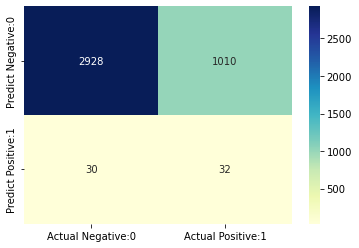

In [41]:
format_confusion_matrix(y_test, test_predictions_lgbm)

In [42]:
test_predictions_lgbm_proba = lgbm_final.predict_proba(X_test_data)

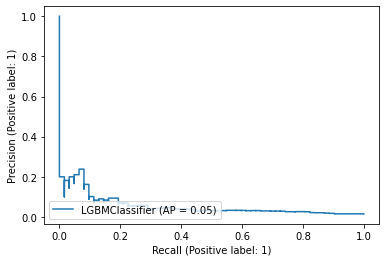

In [43]:
PrecisionRecallDisplay.from_estimator(lgbm_final, X_test_data, y_test)

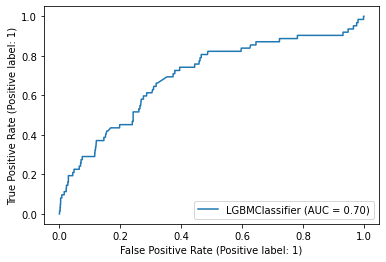

In [44]:
RocCurveDisplay.from_estimator(lgbm_final, X_test_data, y_test)

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

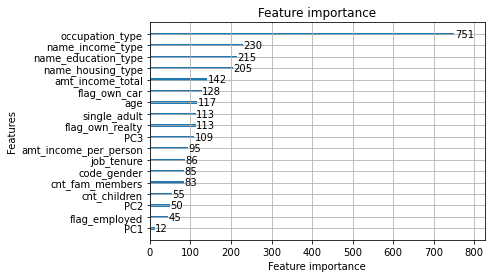

In [45]:
lgb.plot_importance(lgbm_final)

## Hyperparameter tuning for Random Forest

In [46]:
criterion_choices = ["gini", "entropy"]
max_features_choices = ['sqrt', 'log2', None]

rf_reg_params = {
    'n_estimators':     hp.choice('n_estimators', np.arange(5, 3000, 1, dtype=int)),
    'max_depth':        hp.choice('max_depth', np.arange(2, 15, 1, dtype=int)),
    'min_samples_leaf': hp.uniform('min_samples_leaf',0.01, 0.3), 
    'criterion':        hp.choice("criterion", criterion_choices),
    'max_features':     hp.choice('max_features', max_features_choices)        
}

def obj_fun_rf(params):
    rf = RandomForestClassifier(class_weight='balanced', **params)
    rf.fit(X_train_data, y_train_data)
    train_cv_score = cross_val_score(rf, X_train_data, y_train_data, scoring="average_precision", cv = 5).mean()
    return -1.0 * train_cv_score

X_train_data = X_train_balanced_one_hot
y_train_data = y_train_balanced_one_hot
X_test_data = X_test_one_hot
y_test_data = y_test
        
trials_rf = Trials()
hyperopt_params_rf = fmin(
    fn = obj_fun_rf,                 # objective function
    space = rf_reg_params,           # parameter space
    algo = tpe.suggest,              # surrogate algorithm
    max_evals = 100,                 # no. of evaluations
    trials = trials_rf,              # trials object that keeps track of the sample results (optional)
    rstate = np.random.default_rng(seed)
)

100%|████████████████████████████████████████████████████████████| 100/100 [43:43<00:00, 26.23s/trial, best loss: -0.9230529060305974]


In [47]:
hyperopt_params_rf

{'criterion': 0,
 'max_depth': 12,
 'max_features': 2,
 'min_samples_leaf': 0.010102612711620503,
 'n_estimators': 1403}

In [48]:
hyperopt_params_rf = {'criterion': criterion_choices[hyperopt_params_rf['criterion']],
                       'max_depth': hyperopt_params_rf['max_depth'],
                       'max_features': max_features_choices[hyperopt_params_rf['max_features']],
                       'n_estimators': hyperopt_params_rf['n_estimators']}

In [49]:
hyperopt_params_rf

{'criterion': 'gini',
 'max_depth': 12,
 'max_features': None,
 'n_estimators': 1403}

In [50]:
# extract_and_plot_hyperopt_trials(trials_rf)

## Fitting model with selected params

In [51]:
rf_final = RandomForestClassifier(class_weight='balanced', **hyperopt_params_rf)
rf_final = rf_final.fit(X_train_data, y_train_data)

In [52]:
save_intermin_data_and_model(X_train_data, y_train_data, X_test_data, y_test_data, rf_final, 'rf')

### Model performance

In [53]:
train_cv_score_rf = cross_val_score(rf_final, X_train_data, y_train_data, scoring="average_precision", cv = 5, n_jobs=-1).mean()
print("train cv score: " + str(round(train_cv_score_rf, 2)))

train cv score: 0.99


In [54]:
test_predictions_rf = rf_final.predict(X_test_data)
summarise_metrices(y_test = y_test, y_hat = test_predictions_rf)

average_precision test: 0.05
f1 test: 0.17
precision test: 0.11
recall test: 0.4


<AxesSubplot:>

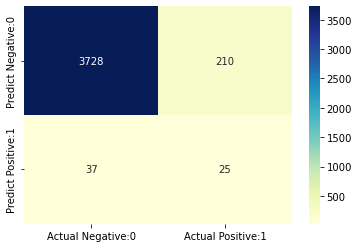

In [55]:
format_confusion_matrix(y_test, test_predictions_rf)

In [56]:
test_predictions_rf_proba = rf_final.predict_proba(X_test_data)

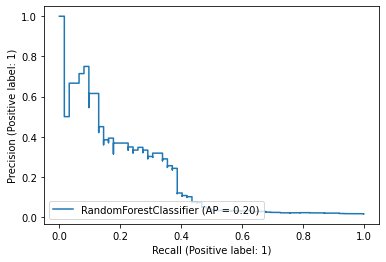

In [57]:
PrecisionRecallDisplay.from_estimator(rf_final, X_test_data, y_test)

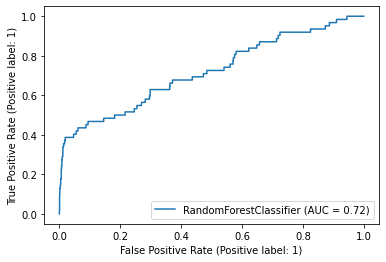

In [58]:
RocCurveDisplay.from_estimator(rf_final, X_test_data, y_test)

### Feature importance

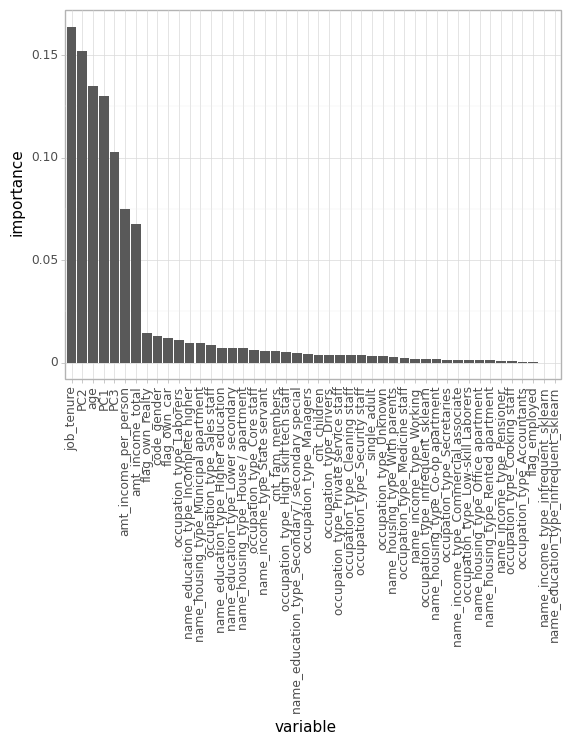

In [59]:
get_rf_feature_imp(rf_final)

# Final classification on test set

In [60]:
final_model = rf_final
test_predictions_final = test_predictions_rf
test_predictions_proba_final = test_predictions_rf_proba

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions_final))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3938
           1       0.11      0.40      0.17        62

    accuracy                           0.94      4000
   macro avg       0.55      0.67      0.57      4000
weighted avg       0.98      0.94      0.96      4000



In [62]:
tbl_results_roc = pd.DataFrame()
tbl_results_roc['fpr'], tbl_results_roc['tpr'], tbl_results_roc['thresholds'] = roc_curve(y_test, test_predictions_proba_final[:,1])

In [63]:
tbl_results_pr = pd.DataFrame()

precision, recall, thresholds = precision_recall_curve(y_test[:], test_predictions_proba_final[:,1])
thresholds = np.append(thresholds, 1)

tbl_results_pr['precision'] = precision
tbl_results_pr['recall'] = recall
tbl_results_pr['thresholds'] = thresholds
tbl_results_pr['fscore'] = compute_f1(tbl_results_pr.precision, tbl_results_pr.recall)

## Results for default threshold = 0.5

In [64]:
print('Default threshold 0.5')
get_summary(tbl_results_pr, 0.5)

Default threshold 0.5


,precision,recall,thresholds,fscore
2699,0.106383,0.403226,0.500291,0.16835


In [65]:
get_summary(tbl_results_roc, 0.5)

,fpr,tpr,thresholds
88,0.052565,0.403226,0.501287


<AxesSubplot:>

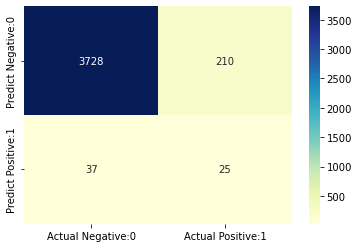

In [66]:
format_confusion_matrix(y_test, test_predictions_final)

## Results for best threshold

In [67]:
# locate the index of the largest f score
ix = np.argmax(tbl_results_pr.fscore)
best_threshold = tbl_results_pr.thresholds[ix]

In [68]:
print('Best Threshold: ' + str(best_threshold))
get_summary(tbl_results_pr, best_threshold)

Best Threshold: 0.8376492063572392


,precision,recall,thresholds,fscore
2829,0.318182,0.33871,0.837649,0.328125


In [69]:
get_summary(tbl_results_roc, best_threshold)

,fpr,tpr,thresholds
34,0.011427,0.33871,0.837649


<AxesSubplot:>

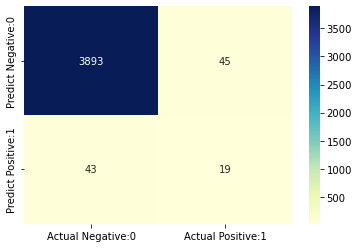

In [70]:
test_predictions_threshold_final = reclassify_by_treshold(test_predictions_proba_final, best_threshold)
format_confusion_matrix(y_test, test_predictions_threshold_final)